<a href="https://colab.research.google.com/github/KIllerLB-USTC/BZ-Oregonator-/blob/main/Distance_depth_raman_treatment%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install peakutils rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
import os
import pandas as pd
import peakutils
from peakutils.plot import plot as pplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def file_typename_finder(file_dir,position,print_name=False):
    target_file_name= []
    for root, dirs, files in os.walk(file_dir):
      for file in files:
        file_name = file.split('_')[position]
        if print_name == True:
          print(file_name+'\t'+ str(file))
        if file_name not in target_file_name:
          target_file_name.append(file_name)
    print(target_file_name)
    return target_file_name

def file_name_walk_finder(file_dir,target_KEY_WORDS):
    target_file =[]
    for root, dirs, files in os.walk(file_dir):
      for file in files:
        if target_KEY_WORDS['time']==[] and file.split('_')[2] in target_KEY_WORDS['voltage']:
          target_file.append(file)
          print(file)

        elif file.split('_')[2] in target_KEY_WORDS['voltage'] and file.split('_')[1] in target_KEY_WORDS['time']:
          target_file.append(file)
          print(file)
    return target_file

def condition_translator(file_name):
  condition = file_name.split('_')[2] 
  if condition == 'N100mv':
    result = 'Voltage:0.1V,-'
  elif condition == 'N50mv':
    result = 'Voltage:0.05V,-'
  elif condition == 'N150mv':
    result = 'Voltage:0.15V,-'
  elif condition == 'N200mv' or condition == '200mvp' :
    result = 'Voltage:0.2V,-'
  elif condition == 'N300mv':
    result = 'Voltage:0.3V,-'
  elif condition == 'N400mv':
    result = 'Voltage:0.4V,-'
  elif condition == 'N500mv':
    result = 'Voltage:0.5V,-'
  elif condition == 'N600mv':
    result = 'Voltage:0.6V,-'
  elif condition == 'P200mv':
    result = 'Voltage:0.2V,+'
  elif condition == 'P400mv':
    result = 'Voltage:0.4V,+'
  elif condition =='bare':
    result = 'Nosolution,NoITOglass'
  elif condition =='0mv' or condition == '0vpp':
    result ='Voltage:0.00V'
  else: print(file_name+'\t there is no translation for this file accrodingly')
  Solution =file_name.split('_')[0].lower() +'_'+ file_name.split('_')[1].lower()
  list_dic = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']
  tiny_time = file_name.split('_')[-1].split('.')[0].lower()

  time_period = file_name.split('_')[2]
  if time_period == '0-200s':
    time_s = str(list_dic.index(tiny_time)*5) + 'S'
  elif time_period== '200-400s':
    time_s = str(list_dic.index(tiny_time)*5+200) + 'S'
  elif time_period == '400-600s':
    time_s = str(list_dic.index(tiny_time)*5+400) + 'S'
  elif time_period == '600-800s':
    time_s = str(list_dic.index(tiny_time)*5+600) + 'S'
  
  condition_describ = time_s  +','+ result+ ','+Solution
  return condition_describ

def data_set_generator(file_dir,KEY_WORDS,Rough_refrence_peak_for_normalize,smooth_ratio):
  index = 0
  deal_file_list = file_name_walk_finder(file_dir,KEY_WORDS)
  for file_name in deal_file_list: 

    deal_file = os.path.join(file_dir,file_name)
    df = pd.read_csv(deal_file, sep="\t", header=None)
    df.columns = [ "wave Number","intensity"]
    df['Conditions'] = condition_translator(file_name)
    # Find the si_peak
    inte = df.loc[(df['wave Number']>Rough_refrence_peak_for_normalize-1) & (df['wave Number']<Rough_refrence_peak_for_normalize+1) ]['intensity']
    number = inte.iloc[0].max()*smooth_ratio
    df['Normalized'] = df['intensity'].div(number)


    index += 1 
    if index == 1:
      df_merge = df
    if index >1:
      df_merge = pd.concat([df_merge, df], ignore_index='True')
  return df_merge


def each_time_plot(database,legend_name,Normalized_or_Not):

  if Normalized_or_Not == True:
    button = 'Normalized'
  else:
    button ='intensity'
  sns.set_theme(style="dark")
  flights = database

  # Plot each year's time series in its own facet
  g = sns.relplot(
      data=flights,
      x="wave Number", y=button, col="Conditions", hue="Conditions",
      linewidth=3, zorder=5,kind="=-6", palette="crest",
      col_wrap=3, height=3, aspect=1.5, legend=False,
  )

  # Iterate over each subplot to customize further
  for condition, ax in g.axes_dict.items():

      # Add the title as an annotation within the plot
      ax.text(.8, .85, condition, transform=ax.transAxes, fontweight="bold")

      # Plot every year's time series in the background
      sns.lineplot(
          data=flights, x="wave Number", y=button, 
          estimator=None, color=".7", linewidth=1, ax=ax,
      )

  # Reduce the frequency of the x axis ticks
  ax.set_xticks(ax.get_xticks()[::2])

  # Tweak the supporting aspects of the plot
  g.set_titles(legend_name +' '+ "for different time")
  g.set_axis_labels("Wave number ($cm^{-1}$)", "Intensity")
  g.tight_layout()

  #### 3D Plot 
  def pick_up_the_time_line(file_dir,target_KEY_WORDS,Plot_time_gap):
    target_file =file_name_walk_finder(file_dir,target_KEY_WORDS)
    for file in target_file:
      file.split('_')

    return target_file


##CLassify the files by differents in Folders

In [ ]:
def move_file_keepname(file_dir,destination,file_name):
  ### file_dir the file stored path, destination is the target folder absolute path
    source_path = os.path.join(file_dir,file_name)
    destination_path = os.path.join(destination,file_name)
    os.rename(source_path,destination_path)
    print('Moving\t<'+file_name+'>successed from\t'+file_dir+'to\t'+destination)

def file_difference_path_creator(file_dir,cut_off_poistion):
    target_file =[]
    target_classify_byfolder = []
    counting_num = 0
    files_and_folders = os.listdir(file_dir)

    for item in files_and_folders:
        if os.path.isdir(item):
            target_classify_byfolder.append(item)
    for root, dirs, files in os.walk(file_dir):
      for file in files:
        if file.split('_')[cut_off_poistion] not in target_classify_byfolder:
          name = file.split('_')[cut_off_poistion]
          target_classify_byfolder.append(name)
          creatdir = os.path.join(file_dir,name)
          os.makedirs(creatdir,exist_ok=True)
          print('Creating\t' + name + ' dir now')
          move_file_keepname(file_dir,creatdir,file)
        else:
          name = file.split('_')[cut_off_poistion]
          target_dir = os.path.join(file_dir,name)
          move_file_keepname(file_dir,target_dir,file)
        counting_num += 1
      print('finished classify the file\t NUM:%d,Creating the folder:%s,folder_numer:%d'%(counting_num,target_classify_byfolder,len(target_classify_byfolder)))


In [ ]:
path ='/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2'

file_typename_finder(path,-5)

['-400mv,41min', '-400mv,46min', '-400mv,51min', '-400mv,56min', '-800mv,106min', '-800mv,101min', '-800mv,110min', '-800mv,86min', '-800mv,91min', '-800mv,96min', 'shutdown -400mv,61min', 'shutdown -400mv,66min', 'shutdown -400mv,71min', 'shutdown -400mv,76min', 'shutdown -400mv,81min', '0v,0min', '0v,15min', '0v,10min', '0v,20min', '0v,25min', '0v,30min', '0v,35min', '-400mv,36min', '0v,5min']


['-400mv,41min',
 '-400mv,46min',
 '-400mv,51min',
 '-400mv,56min',
 '-800mv,106min',
 '-800mv,101min',
 '-800mv,110min',
 '-800mv,86min',
 '-800mv,91min',
 '-800mv,96min',
 'shutdown -400mv,61min',
 'shutdown -400mv,66min',
 'shutdown -400mv,71min',
 'shutdown -400mv,76min',
 'shutdown -400mv,81min',
 '0v,0min',
 '0v,15min',
 '0v,10min',
 '0v,20min',
 '0v,25min',
 '0v,30min',
 '0v,35min',
 '-400mv,36min',
 '0v,5min']

In [ ]:
## Check before run this cube
file_difference_path_creator(path,-5)

Creating	-400mv,41min dir now
Moving	<SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_66.txt>successed from	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2to	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2/-400mv,41min
Creating	-400mv,46min dir now
Moving	<SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_28.txt>successed from	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2to	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2/-400mv,46min
Moving	<SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_46.txt>successed from	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2to	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2/-400mv,46min
Moving	<SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_45.txt>successed from	/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2to	/content/drive/MyDrive/a

In [ ]:
path ='/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G/'
file_difference_path_creator(path,0)

## Extract the max signal value from Spectra

In [ ]:
from posixpath import join
from posixpath import split
from pandas.io.parsers.readers import read_table
from tqdm import tqdm


# KEY_WORDS = {'voltage':['N50mv'],'time':['0-200s']}
# file_list = file_name_walk_finder(file_path,KEY_WORDS)

def i_distance_graph_value_return(file_path,distance_gap=30,show_peak_positon=False,show_files_details = False,calibration_distance_factor = 0):

  file_list = os.listdir(file_path)
  ##默认没有文件夹
  print('the distance gap is %d um'%distance_gap)
  plot_list = np.array([[0,0]])
  file_list_bar = tqdm(file_list)
  for file in file_list_bar:

    distance_count = int(file.split('_')[-1].split('.')[0].lower())-calibration_distance_factor
    # time_count_list.append(time_count*10+initial_num)
    files = os.path.join(file_path,file)
    if show_files_details == True:
      print(files)
    df = pd.read_table(files,names=['wave number','intensity'],sep='\\s+',encoding='utf-8')
    df = df.loc[df['wave number']>400].reset_index()
    y = df['intensity']
    #base = peakutils.baseline(y,0)
    
    # if Autopickfinder_FLAG == True:
      
    #   indexes = peakutils.indexes(y-base,thres=0.01,min_dist=20)
    #   ## Debug and check the peak finder
    #   print(indexes)
    #   #index = indexes[np.where((indexes<135)&(indexes>130))]
    #   Y_2=0
    #   for indexe in indexes:
    #     if 700 <df['wave number'].loc[indexe]<750:
    #       index = indexe
    #       #### debug
    #       print(df['wave number'].loc[indexe])
    #       Y_2 = df['intensity'].loc[index]-base[index]
    # else: 
    #   index =df['wave number'].idmax
    #   Y_2 = df['intensity'].loc[index]-base[index]
    #   print(df['wave number'].loc[index])
      
    index =df['intensity'].idxmax()
    Y_2 = df['intensity'].loc[index]#-base[index]
    if show_peak_positon == True:
       print(df['wave number'].loc[index])
        
    # target_y.append(Y_2)
    #print(index)

    plot_list =np.append(plot_list,[[distance_count*distance_gap,Y_2]],axis=0)
    # print(np.argsort(plot_list[:,0]))

    plot_list = plot_list[np.argsort(plot_list[:,0])]
    # print(plot_list)
    file_list_bar.set_description('Now processing inner circle...%s'%file)
  if show_peak_positon == True:
   print(plot_list)
  return plot_list


In [ ]:
os.listdir('/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on Au')

['FTO,0mv', 'FTO,-1V', 'FTO,+1V', 'FTO,+2V', 'FTO,0mv,2', 'FTO,0mv,3']

In [ ]:

from matplotlib import text
import matplotlib.pyplot as plt
from pandas.core import indexes
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re




def return_folders_path(path):
  path_list = []
  for top,dirs,files in os.walk(path):
    for dir in dirs:
      path=os.path.join(top,dir)
      path_list.append(path)
  return path_list


def return_files_path(path):
  file_list = []
  for top,dirs,files in os.walk(path):
    for file in files:
      path=os.path.join(top,file)
      file_list.append(path)
  return file_list

def delete_upper_class_folder_path(path_list):
  for path in path_list:
    file_list = os.listdir(path)
    for file in file_list:
      #print(file)
      if os.path.isdir(os.path.join(path,file)):
        path_list.remove(path)
        print('removing upper folder%s'%path)
        break#遇到第一个folder 删除上级路径
  return path_list

def second_largest(a_array):
  m1 = a_array.max()
  b =np.delete(a_array,np.where(a_array == m1))
  m2 = b.max()
  return m2

def List_sort(a_list):
  fns = lambda s: sum(((s,int(n))for s,n in re.findall('(\D+)(\d+)','a%s0'%s)),())
  return sorted(a_list, key=fns)
  ### Ref 

def parse_time(time_str):
    voltage, time = time_str.split(',')
    match = re.match(r'(\d+)\s*(\S+)', time)
    if not match:
        raise ValueError('Invalid time string')
    value = int(match.group(1))
    unit = match.group(2)
    if unit == 'min':
        return value
    elif unit == 'sec':
        return value / 60
    elif unit == 'hr':
        return value * 60
    else:
        raise ValueError('Invalid time unit')

def sort_times(times):
    sorted_times = sorted(times, key=parse_time)
    return sorted_times

  
def Time_dependent_raman_drawing(tot_folder_path,save_path,time_gap,description_label='',normalization = 'overall',line_color =[],ylim_scale=()):

  Upper_folder_path = tot_folder_path
  condition_list =[]
  path_c = List_sort(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  fig, ax = plt.subplots(figsize=(6,4),dpi=200)
  #plt.ylim((0,1.1))
  cali_factor =0

  ###
  
  if normalization == 'overall':
    y_max = 1
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path,distance_gap=time_gap)
      
      if y_max < plot_list[1:,1].max():
        y_max = plot_list[1:,1].max()
        print('\nThe Normalization y_max =%.2f'%y_max)
    print('\nThe Normalization found! y_max =%.2f'%y_max)


  for path in path_bar:
    files_list = return_files_path(path)
    condition = description_label+','+path.split('/')[-2]+','+path.split('/')[-1]
    condition_list.append(condition)
    # plot_path = os.path.join(Upper_folder_path,file)
    # file_path = plot_path
    #plt.xlim((50,600))
    
    plot_list = i_distance_graph_value_return(path,distance_gap=time_gap,show_peak_positon=False)

    x_value = plot_list[1:,0]
    if normalization == 'overall':
      y_value = plot_list[1:,1]/y_max #* parameter[count]
    elif normalization == 'individual':
      #y_value = plot_list[1:,1]/second_largest(plot_list[1:,1])
      y_value = plot_list[1:,1]/plot_list[1:,1].max()
    else:
      y_value = plot_list[1:,1]

    if line_color:
      for color in line_color:
        ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2,color=color)
    else:
      ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2)
    print('finished drawing <%s> figure'%condition)
    path_bar.set_description('Now processing...%s'%condition)
  ax.legend(condition_list,fontsize=4,loc='upper left')
  ax.set(ylabel='Flourencence Intensity(Count.)R6G',xlabel='Time(s)')
  ax.set(title= '%s I-t graph'%description_label)
  ax.title.set_size(8)
  ### autoscale or manually
  if ylim_scale:
    plt.ylim(ylim_scale)
  else:
    ax.autoscale()
  plt.savefig(save_path+'%s%s.png'%(Upper_folder_path.split('/')[-1],description_label),dpi=600) 

  
def Distance_raman_drawing(tot_folder_path,save_path,tiltle,description_label='',normalization = 'raw',calibration_for_time_shift = False):

  Upper_folder_path = tot_folder_path
  condition_list =[]
  path_c = List_sort(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  fig, ax = plt.subplots(figsize=(6,4),dpi=200)
  #plt.ylim((0,1.1))
  cali_factor =0

  ###
  
  if normalization == 'overall':
    y_max = 1
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path)
      
      if y_max < plot_list[1:,1].max():
        y_max = plot_list[1:,1].max()
        print('\nThe Normalization y_max =%.2f'%y_max)
    print('\nThe Normalization found! y_max =%.2f'%y_max)

  if normalization == 'max_peak_plot':
    max_position =[]
    max_intensity = []
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path)
      
      max_intensity.append(plot_list[:,1].max())
      x,y = np.where(plot_list==plot_list[:,1].max())
      max_position.append(plot_list[x,0])
    print(max_position)
    print(max_intensity)


#####
  for path in path_bar:
    files_list = return_files_path(path)
    condition = description_label+''+path.split('/')[-2]+','+path.split('/')[-1]
    condition_list.append(condition)
    # plot_path = os.path.join(Upper_folder_path,file)
    # file_path = plot_path
    #plt.xlim((50,600))
    if calibration_for_time_shift == True :
      
      plot_list = i_distance_graph_value_return(path,show_peak_positon=False,calibration_distance_factor=cali_factor)
      cali_factor += 1
    # elif calibration_for_time_shift == True and cali_factor==6:
    #   plot_list = i_distance_graph_value_return(path,show_peak_positon=False,calibration_distance_factor=-3)
    #   cali_factor += 1
    else: 
      plot_list = i_distance_graph_value_return(path,show_peak_positon=False)
      cali_factor += 1
    x_value = plot_list[1:,0] 
    if normalization == 'overall':
      y_value = plot_list[1:,1]/y_max #* parameter[count]
    elif normalization == 'individual':
      #y_value = plot_list[1:,1]/second_largest(plot_list[1:,1])
      y_value = plot_list[1:,1]/plot_list[1:,1].max()
    elif normalization == 'max_peak_plot':
      x_value = max_position
      y_value = max_intensity
    else:
      y_value = plot_list[1:,1]
    ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2)
    print('finished drawing <%s> figure'%condition)
    path_bar.set_description('Now processing...%s'%condition)
  ax.legend(condition_list,fontsize=4,loc='best')
  ax.set(ylabel='Flourencence Intensity(Count.)',xlabel='Displacement($\mu$m)')
  ax.set(title= '%s I-D graph'%tiltle)
  ax.title.set_size(12)
  ax.autoscale()
  plt.savefig(save_path+'%s%s.png'%(Upper_folder_path.split('/')[-1],description_label),dpi=600) 

def get_maxpoints_position_value(tot_folder_path,peak_confine =True,peak_position_approx=(1500,1600)):
  Upper_folder_path = tot_folder_path
  condition_list =[]
  #path_c = List_sort(return_folders_path(Upper_folder_path))
  path_c = sort_times(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  max_position =[]
  max_intensity = []
  for path in path_bar:
    condition = path.split('/')[-1] 
    condition_list.append(condition)
    plot_list = i_distance_graph_value_return(path)
    if peak_confine == True:
      start,end = peak_position_approx
      peak_position = np.where((plot_list[:,0]>start) & (plot_list[:,0]<end))
      peak_intensity = plot_list[peak_position,1].max()
      max_intensity.append(peak_intensity)
      x,y = np.where(plot_list==peak_intensity)
      max_position.append(plot_list[x,0])
    else:
      max_intensity.append(plot_list[:,1].max())
      x,y = np.where(plot_list==plot_list[:,1].max())
      max_position.append(plot_list[x,0])
  #print(max_position)
  #print(max_intensity)
  return max_position,max_intensity,condition_list

In [ ]:
times = ['80mv,6min', '90mv,1min']
sorted_times = sort_by_times(times)
print(sorted_times)


['90mv,1min', '80mv,6min']


In [ ]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
b = second_largest(a)
print(b)

8


In [ ]:
upper_class_path = '/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2/'
save_path =upper_class_path
solution_concentration = 'R6G 1e-7M ' 
name = 'BSA coated SINW samples ' + solution_concentration
label= ''
mode1 = 'individual'
mode2 ='overall'
mode3 ='raw'
# Distance_raman_drawing(upper_class_path,save_path,name+mode1,mode1,calibration_for_time_shift = False)
# Distance_raman_drawing(upper_class_path,save_path,name+mode2,mode2,calibration_for_time_shift = False)
Distance_raman_drawing(upper_class_path,save_path,name,label,mode3,calibration_for_time_shift = False)

In [ ]:
upper_class_path = '/content/drive/MyDrive/analysis/Raman_analyze/20230127 r6g/5um PMMA coated sinw voltage/Voltage applied queching test/'
save_path =upper_class_path
time_gap = 6 #'s'
name = '-1v applied quenching test at middle of well, time Gap 6s, $10^{-7}$ M R6G '
mode1 ='raw'
mode2 = 'overall'
Time_dependent_raman_drawing(upper_class_path,save_path,time_gap,name+mode1,mode1)
Time_dependent_raman_drawing(upper_class_path,save_path,time_gap,name+mode2,mode2)


In [ ]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [ ]:
upper_class_path = '/content/drive/MyDrive/analysis/raman_analysis_/20230226week/solution2/'
save_path = upper_class_path
description_label = 'Z-axis scanning tests, Peak signal change with time at silicon surface'
position,intensity,condition_label=get_maxpoints_position_value(upper_class_path,peak_position_approx=(0,1000))
###Read

  0%|          | 0/24 [00:00<?, ?it/s]

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_8.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_22.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_38.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_6.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_43.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_43.txt:   7%|▋         | 5/75 [00:00<00:01, 38.94it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,0min_forward_sysmmetry_location_25.txt:   7%|▋         | 5/75 [00:00<00:01, 38.94it/s]


the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_23.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_50.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_68.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_73.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_52.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_52.txt:   7%|▋         | 5/75 [00:00<00:01, 45.46it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,5min_forward_sysmmetry_location_33.txt:   7%|▋         | 5/75 [00:00<00:01, 45.46it/s]

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_21.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_34.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_70.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_75.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_19.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_64.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,10min_forward_sysmmetry_location_64.txt:   8%|▊         | 6/75 [00:00<00:01, 48.18it/s]


the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_7.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_3.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_1.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_8.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_9.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_2.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,15min_forward_sysmmetry_location_5.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing 

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_11.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_5.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_32.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_9.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_36.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,20min_forward_sysmmetry_location_16.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now proc

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_65.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_40.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_18.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_20.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_20.txt:   7%|▋         | 5/75 [00:00<00:01, 45.23it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,25min_forward_sysmmetry_location_15.txt:   7%|▋         | 5/75 [00:00<00:01, 45.

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_1.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_55.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_75.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_69.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_16.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_38.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,30min_forward_sysmmetry_location_45.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now proce

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_8.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_47.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_32.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_32.txt:   4%|▍         | 3/75 [00:00<00:02, 29.07it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_18.txt:   4%|▍         | 3/75 [00:00<00:02, 29.07it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_23.txt:   4%|▍         | 3/75 [00:00<00:02, 29.07it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_0v,35min_forward_sysmmetry_location_25.txt:   4%|▍         | 3/75 [0

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_7.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_13.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_1.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_15.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_15.txt:   5%|▌         | 4/75 [00:00<00:02, 35.41it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_3.txt:   5%|▌         | 4/75 [00:00<00:02, 35.41it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,36min_forward_sysmmetry_location_14.txt:   5%

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_66.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_63.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_62.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_69.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_60.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_68.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,41min_forward_sysmmetry_location_68.txt:   8%|▊         | 6/

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_28.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_46.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_45.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_59.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_19.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_56.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,46min_forward_sysmmetry_location_14.txt:   0%|          | 0/

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_19.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_17.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_24.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_24.txt:   5%|▌         | 4/75 [00:00<00:01, 37.59it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_13.txt:   5%|▌         | 4/75 [00:00<00:01, 37.59it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,51min_forward_sysmmetry_location_11.txt:   5

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_39.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_47.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_70.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_19.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_24.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-400mv,56min_forward_sysmmetry_location_61.txt:   0%|          | 0/

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,61min_forward_sysmmetry_location_3.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,61min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,61min_forward_sysmmetry_location_13.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,61min_forward_sysmmetry_location_4.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,61min_forward_sysmmetry_location_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,61min_forward_sysmmetry_location_12.txt:   7%|▋         | 5/75 [00:00<00:01, 39.57it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdo

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,66min_forward_sysmmetry_location_6.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,66min_forward_sysmmetry_location_27.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,66min_forward_sysmmetry_location_28.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,66min_forward_sysmmetry_location_9.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,66min_forward_sysmmetry_location_42.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,66min_forward_sysmmetry_location_13.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400m

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,71min_forward_sysmmetry_location_72.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,71min_forward_sysmmetry_location_13.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,71min_forward_sysmmetry_location_30.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,71min_forward_sysmmetry_location_9.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,71min_forward_sysmmetry_location_26.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,71min_forward_sysmmetry_location_33.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,76min_forward_sysmmetry_location_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,76min_forward_sysmmetry_location_8.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,76min_forward_sysmmetry_location_2.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,76min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,76min_forward_sysmmetry_location_15.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,76min_forward_sysmmetry_location_4.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400m

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,81min_forward_sysmmetry_location_56.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,81min_forward_sysmmetry_location_29.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,81min_forward_sysmmetry_location_50.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,81min_forward_sysmmetry_location_25.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,81min_forward_sysmmetry_location_57.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400mv,81min_forward_sysmmetry_location_5.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_shutdown -400

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_1.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_4.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_6.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_37.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_31.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,86min_forward_sysmmetry_location_40.txt:   0%|          | 0/75

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_18.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_25.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_24.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_34.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_35.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,91min_forward_sysmmetry_location_46.txt:   0%|          | 0/

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_5.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_70.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_42.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_35.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_29.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,96min_forward_sysmmetry_location_33.txt:   0%|          | 0/7

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_18.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_4.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_59.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_71.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_15.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_70.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,101min_forward_sysmmetry_location_68.txt:   0%|       

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_6.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_36.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_10.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_28.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_8.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_11.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,106min_forward_sysmmetry_location_25.txt:   0%|        

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_1.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_71.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_31.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_21.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_61.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...SINW_R6G1e-7_290ND_ITo_-800mv,110min_forward_sysmmetry_location_5.txt:   0%|         

[array([390]), array([420]), array([420]), array([450]), array([480]), array([510]), array([540]), array([570]), array([480]), array([510]), array([570]), array([600]), array([630]), array([240]), array([630]), array([300]), array([570]), array([270]), array([330]), array([360]), array([300]), array([390]), array([420]), array([480])]


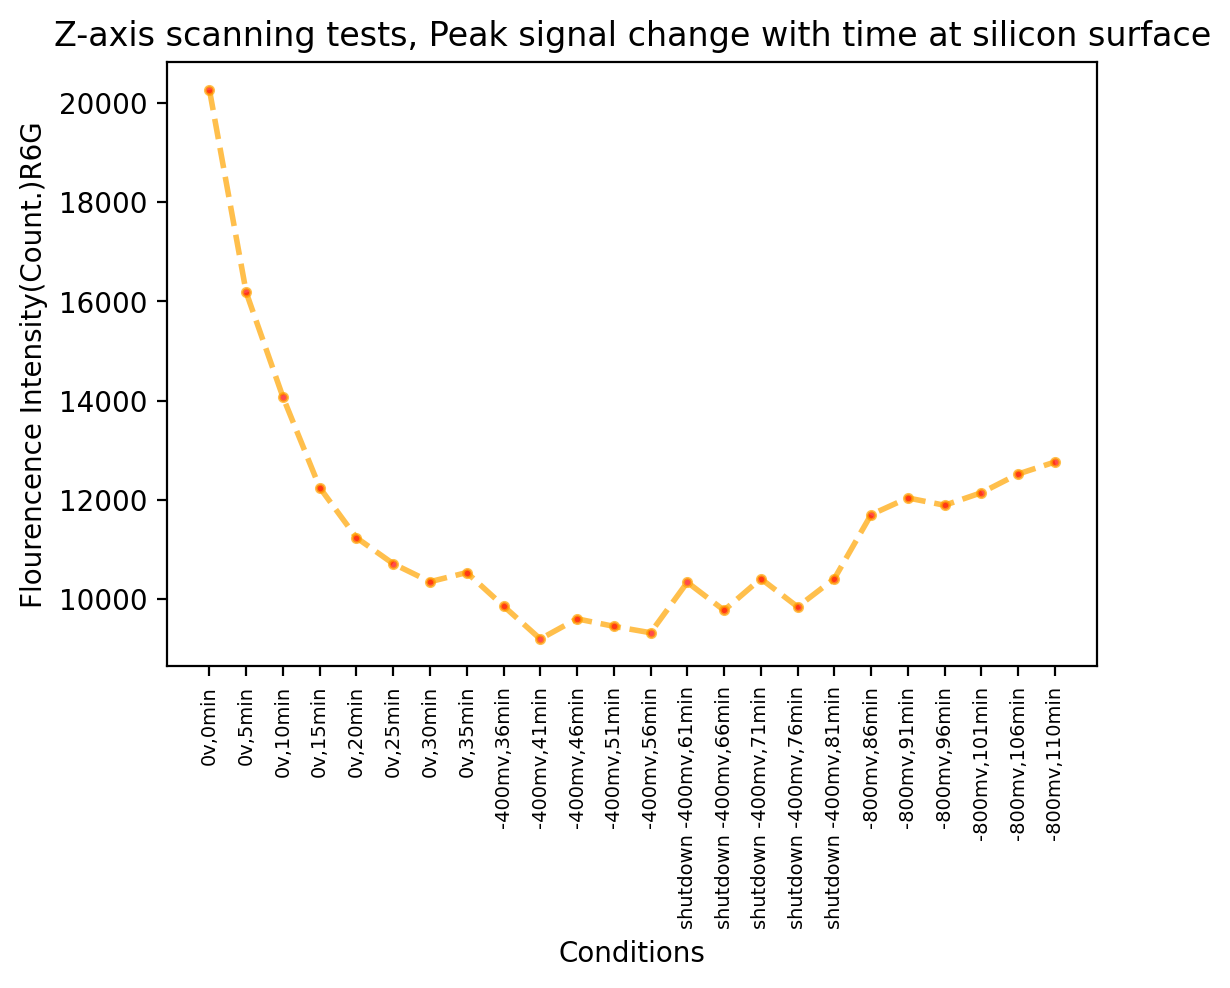

In [ ]:
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
x = [i+1 for i in range(len(intensity))]
x_labels = condition_label 
plt.xticks(x, x_labels,fontsize=7)
ax.plot(x , intensity,'.--',color='orange',markerfacecolor='red',alpha = .7,linewidth=2)
ax.tick_params(axis='x', rotation=90)

# ax.legend(condition_list,fontsize=4,loc='upper left')
ax.set(ylabel='Flourencence Intensity(Count.)R6G',xlabel='Conditions')
ax.set(title= '%s'%description_label)
#ax.set_ylim(20000,30000)
# ax.title.set_size(8)
ax.autoscale()
plt.savefig(save_path+'%s%s.png'%(upper_class_path.split('/')[-1],description_label),dpi=600)
print(position)

##drawing the plot


In [ ]:
import re

def parse_time(time_str):
    voltage, time = time_str.split(',')
    match = re.match(r'(\d+)\s*(\S+)', time)
    if not match:
        raise ValueError('Invalid time string')
    value = int(match.group(1))
    unit = match.group(2)
    if unit == 'min':
        return value
    elif unit == 'sec':
        return value / 60
    elif unit == 'hr':
        return value * 60
    else:
        raise ValueError('Invalid time unit')

def sort_times(times):
    sorted_times = sorted(times, key=parse_time)
    return sorted_times

times = ['80mv,3min', '110mv,110min', '90mv,6min', '60mv,1hr']
sorted_times = sort_times(times)
print(sorted_times)


['80mv,3min', '90mv,6min', '60mv,1hr', '110mv,110min']


In [ ]:
###Debug for max func

path ='/content/drive/MyDrive/analysis/Raman_analyze/20230126 R6G/5um NW/circle3'
plot_list = i_distance_graph_value_return(path,show_peak_positon=False)
print(plot_list)
max_position =[]
max_intensity = []
max_intensity.append(plot_list[:,1].max())
x =np.where((plot_list[:,0]>1500) & (plot_list[:,0]<1600) )
#max_position.append(plot_list[x,0])
print(x)
print(plot_list[x])


the distance gap is 30 um


Now processing inner circle...on PMMA SINW_D.I Water_1.540uw_ITo_0v,0min_forward_sysmmetry_circle4_30.txt: 100%|██████████| 75/75 [00:01<00:00, 59.16it/s]

[[   0    0]
 [  30  630]
 [  60  634]
 [  90  630]
 [ 120  637]
 [ 150  636]
 [ 180  634]
 [ 210  641]
 [ 240  643]
 [ 270  651]
 [ 300  669]
 [ 330  685]
 [ 360  725]
 [ 390  804]
 [ 420  892]
 [ 450  858]
 [ 480  775]
 [ 510  724]
 [ 540  695]
 [ 570  685]
 [ 600  679]
 [ 630  673]
 [ 660  671]
 [ 690  668]
 [ 720  670]
 [ 750  670]
 [ 780  662]
 [ 810  662]
 [ 840  659]
 [ 870  661]
 [ 900  660]
 [ 930  665]
 [ 960  666]
 [ 990  658]
 [1020  657]
 [1050  660]
 [1080  660]
 [1110  665]
 [1140  656]
 [1170  660]
 [1200  655]
 [1230  657]
 [1260  659]
 [1290  659]
 [1320  656]
 [1350  660]
 [1380  651]
 [1410  659]
 [1440  657]
 [1470  662]
 [1500  661]
 [1530  665]
 [1560  667]
 [1590  681]
 [1620  700]
 [1650  688]
 [1680  662]
 [1710  649]
 [1740  649]
 [1770  640]
 [1800  640]
 [1830  648]
 [1860  645]
 [1890  640]
 [1920  635]
 [1950  636]
 [1980  632]
 [2010  633]
 [2040  635]
 [2070  633]
 [2100  638]
 [2130  637]
 [2160  637]
 [2190  637]
 [2220  637]
 [2250  632]]
(array([51,

## Fit Curve of quenching

In [ ]:
from matplotlib import text
import matplotlib.pyplot as plt
from pandas.core import indexes
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from functools import wraps




def return_folders_path(path):
  path_list = []
  for top,dirs,files in os.walk(path):
    for dir in dirs:
      path=os.path.join(top,dir)
      path_list.append(path)
  return path_list


def return_files_path(path):
  file_list = []
  for top,dirs,files in os.walk(path):
    for file in files:
      path=os.path.join(top,file)
      file_list.append(path)
  return file_list

def delete_upper_class_folder_path(path_list):
  for path in path_list:
    file_list = os.listdir(path)
    for file in file_list:
      #print(file)
      if os.path.isdir(os.path.join(path,file)):
        path_list.remove(path)
        print('removing upper folder%s'%path)
        break#遇到第一个folder 删除上级路径
  return path_list

def second_largest(a_array):
  m1 = a_array.max()
  b =np.delete(a_array,np.where(a_array == m1))
  m2 = b.max()
  return m2

def List_sort(a_list):
  fns = lambda s: sum(((s,int(n))for s,n in re.findall('(\D+)(\d+)','a%s0'%s)),())
  return sorted(a_list, key=fns)
  ### Ref 

def fit_curve(degree):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            x, y = func(*args, **kwargs)
            
            poly_features = PolynomialFeatures(degree=degree)
            x_poly = poly_features.fit_transform(x)
            
            model = LinearRegression()
            model.fit(x_poly,y)
            y_pred = model.predict(x_poly)
            r2 =r2_score(y,y_pred)
            plt.plot(x, y_pred, color='red')


            # model2 = LinearRegression()
            # model2.fit(x_poly[100:600],y[100:600])
            # y_pred_2 = model2.predict(x_poly[100:600])
            # r2_2 =r2_score(y[100:600],y_pred_2)
            # plt.plot(x[100:600], y_pred_2, color='orange')
            plt.scatter(x, y, s=10)
            plt.legend(['raw data','Linear Fitting'])
            plt.show()
            
            
            return model.coef_,model.intercept_,r2
        return wrapper
    return decorator



    
# @fit_curve(degree=1)
# def plot_function(ax,x_value,y_value,condition,line_color =[],ylim_scale=(),description_label=''):

#   if line_color:
#       for color in line_color:
#         ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2,color=color)
#   else:
#       ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2)

#   return x_value.reshape(-1,1),y_value
@fit_curve(degree=1)  
def fitting_decorate_time_dependent_raman_drawing(tot_folder_path,save_path,time_gap,description_label='',normalization = 'overall',line_color =[],ylim_scale=()):

  Upper_folder_path = tot_folder_path
  condition_list =[]
  path_c = List_sort(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  fig, ax = plt.subplots(figsize=(6,4),dpi=200)
  #plt.ylim((0,1.1))


  ###
  
  if normalization == 'overall':
    y_max = 1
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path,distance_gap=time_gap)
      
      if y_max < plot_list[1:,1].max():
        y_max = plot_list[1:,1].max()
        print('\nThe Normalization y_max =%.2f'%y_max)
    print('\nThe Normalization found! y_max =%.2f'%y_max)


  for path in path_bar:
    files_list = return_files_path(path)
    condition = description_label+','+path.split('/')[-2]+','+path.split('/')[-1]
    condition_list.append(condition)
    # plot_path = os.path.join(Upper_folder_path,file)
    # file_path = plot_path
    #plt.xlim((50,600))
    plot_list = i_distance_graph_value_return(path,distance_gap=time_gap,show_peak_positon=False)
    
    x_value = plot_list[1:,0]
    if normalization == 'overall':
      y_value = plot_list[1:,1]/y_max #* parameter[count]
    elif normalization == 'individual':
      #y_value = plot_list[1:,1]/second_largest(plot_list[1:,1])
      y_value = plot_list[1:,1]/plot_list[1:,1].max()
    else:
      y_value = plot_list[1:,1]

    if line_color:
      for color in line_color:
        ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2,color=color)
    else:
      ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2)
    print('finished drawing <%s> figure'%condition)
    path_bar.set_description('Now processing...%s'%condition)
  # ax.legend(condition_list,fontsize=4,loc='upper left')
  ax.set(ylabel='Flourencence Intensity(Count.)R6G',xlabel='Time(s)')
  ax.set(title= '%s I-t graph'%description_label)
  ax.title.set_size(8)
  ### autoscale or manually
  if ylim_scale:
    plt.ylim(ylim_scale)
  else:
    ax.autoscale()
  plt.savefig(save_path+'%s%s.png'%(Upper_folder_path.split('/')[-1],description_label),dpi=600) 
  return x_value.reshape(-1,1),y_value


  0%|          | 0/1 [00:00<?, ?it/s]

the distance gap is 6 um



  0%|          | 0/200 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_3.txt:   0%|          | 0/200 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_1.txt:   0%|          | 0/200 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_41.txt:   0%|          | 0/200 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_21.txt:   0%|          | 0/200 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_21.txt:   2%|▏         | 4/200 [00:00<00:05, 38.17it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_14.txt:   2%|▏         | 4/200 [00:00<00:05, 38.17it/s]
Now processing inner 


The Normalization y_max =23706.00

The Normalization found! y_max =23706.00
the distance gap is 6 um


Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0-20min_BLEACHING TEST AT silicon surface_187.txt: 100%|██████████| 200/200 [00:02<00:00, 74.99it/s]


finished drawing <Fitting quenching test silicon surface, time Gap 6s, $10^{-7}$ M R6G overall,test2,BLEACHING TEST AT silicon surface> figure


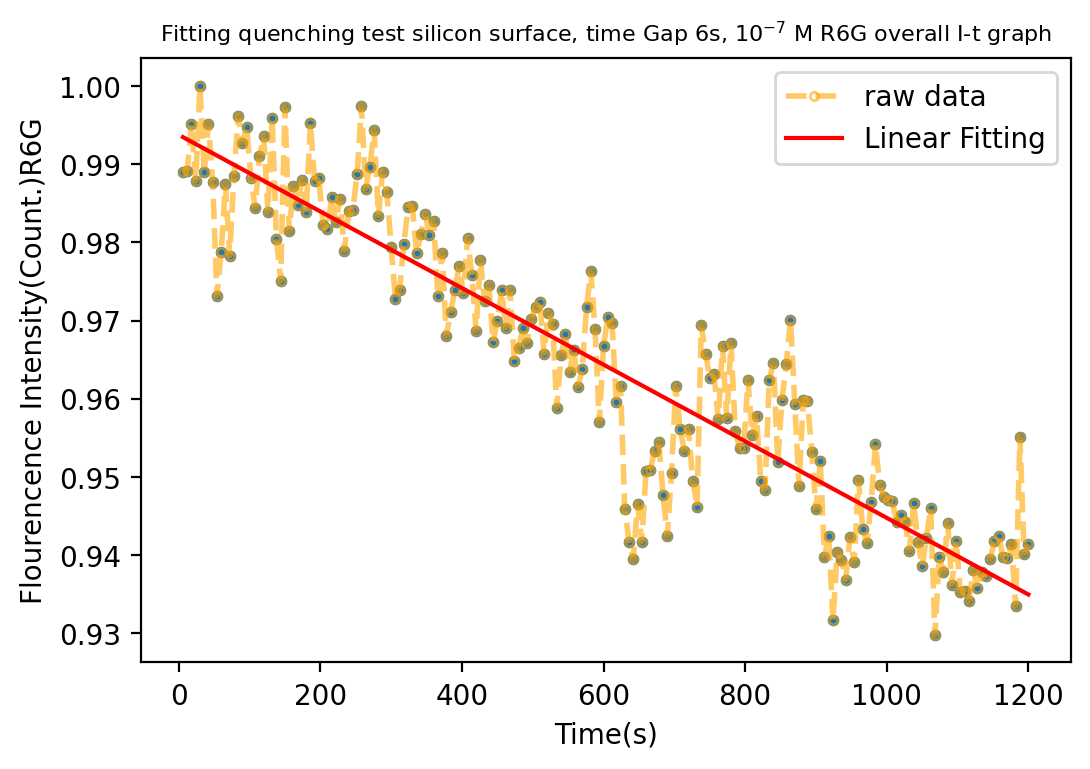

In [ ]:
upper_class_path = '/content/drive/MyDrive/analysis/Raman_analyze/20230127 r6g/5um PMMA coated sinw_2/R6G1e-7/0v Bleaching Test/test2'
save_path =upper_class_path
time_gap = 6 #'s'
name = 'Fitting quenching test silicon surface, time Gap 6s, $10^{-7}$ M R6G '
mode1 ='raw'
mode2 = 'overall'
color = ['orange']
coef,intercept,r2 =fitting_decorate_time_dependent_raman_drawing(upper_class_path,save_path,time_gap,name+mode2,mode2,line_color=color)
#Time_dependent_raman_drawing(upper_class_path,save_path,time_gap,name+mode2,mode2,ylim_scale=(0,1.2))


In [ ]:
expression = np.poly1d(np.append(coef, intercept))
print(expression)
print(r2)

 
-4.897e-05 x + 0.9937
0.8535252314518763


In [ ]:
a=[1,3,4,5,6]
a[2:]

[4, 5, 6]

## ReCalibration the peak
- add using re to find time in condition
- calibration peak using linear fitting result from above

In [ ]:
from matplotlib import text
import matplotlib.pyplot as plt
from pandas.core import indexes
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re




def return_folders_path(path):
  path_list = []
  for top,dirs,files in os.walk(path):
    for dir in dirs:
      path=os.path.join(top,dir)
      path_list.append(path)
  return path_list


def return_files_path(path):
  file_list = []
  for top,dirs,files in os.walk(path):
    for file in files:
      path=os.path.join(top,file)
      file_list.append(path)
  return file_list

def delete_upper_class_folder_path(path_list):
  for path in path_list:
    file_list = os.listdir(path)
    for file in file_list:
      #print(file)
      if os.path.isdir(os.path.join(path,file)):
        path_list.remove(path)
        print('removing upper folder%s'%path)
        break#遇到第一个folder 删除上级路径
  return path_list

def second_largest(a_array):
  m1 = a_array.max()
  b =np.delete(a_array,np.where(a_array == m1))
  m2 = b.max()
  return m2

def List_sort(a_list):
  fns = lambda s: sum(((s,int(n))for s,n in re.findall('(\D+)(\d+)','a%s0'%s)),())
  return sorted(a_list, key=fns)
  ### Ref 

def extract_the_time_from_conditon_first(condition):
  pattern = re.compile(r'\d+')
  time = pattern.search(condition)
  if time:
     time_out = time.group()
     print(time_out) ## return the first match number
  return time_out

def extract_the_time_from_conditon(condition):
  pattern = re.compile(r'\d+')
  time = re.findall(pattern,condition)
  if time:
    print(time)
  return time

def Time_dependent_raman_drawing(tot_folder_path,save_path,time_gap,description_label='',normalization = 'overall',line_color =[],ylim_scale=()):

  Upper_folder_path = tot_folder_path
  condition_list =[]
  path_c = List_sort(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  fig, ax = plt.subplots(figsize=(6,4),dpi=200)
  #plt.ylim((0,1.1))


  ###
  
  if normalization == 'overall':
    y_max = 1
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path,distance_gap=time_gap)
      
      if y_max < plot_list[1:,1].max():
        y_max = plot_list[1:,1].max()
        print('\nThe Normalization y_max =%.2f'%y_max)
    print('\nThe Normalization found! y_max =%.2f'%y_max)


  for path in path_bar:
    files_list = return_files_path(path)
    condition = description_label+','+path.split('/')[-2]+','+path.split('/')[-1]
    condition_list.append(condition)
    # plot_path = os.path.join(Upper_folder_path,file)
    # file_path = plot_path
    #plt.xlim((50,600))
    plot_list = i_distance_graph_value_return(path,distance_gap=time_gap,show_peak_positon=False)
    
    x_value = plot_list[1:,0]
    if normalization == 'overall':
      y_value = plot_list[1:,1]/y_max #* parameter[count]
    elif normalization == 'individual':
      #y_value = plot_list[1:,1]/second_largest(plot_list[1:,1])
      y_value = plot_list[1:,1]/plot_list[1:,1].max()
    else:
      y_value = plot_list[1:,1]

    if line_color:
      for color in line_color:
        ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2,color=color)
    else:
      ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2)
    print('finished drawing <%s> figure'%condition)
    path_bar.set_description('Now processing...%s'%condition)
  ax.legend(condition_list,fontsize=4,loc='upper left')
  ax.set(ylabel='Flourencence Intensity(Count.)R6G',xlabel='Time(s)')
  ax.set(title= '%s I-t graph'%description_label)
  ax.title.set_size(8)
  ### autoscale or manually
  if ylim_scale:
    plt.ylim(ylim_scale)
  else:
    ax.autoscale()
  plt.savefig(save_path+'%s%s.png'%(Upper_folder_path.split('/')[-1],description_label),dpi=600) 

  
def Calibrationed_Distance_raman_drawing(tot_folder_path,save_path
                                         ,description_label='',normalization = 'overall'
                                         ,cali_param_list=[]):

  Upper_folder_path = tot_folder_path
  condition_list =[]
  path_c = List_sort(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  count =0
  fig, ax = plt.subplots(figsize=(6,4),dpi=200)
  #plt.ylim((0,1.1))


  ###
  
  if normalization == 'overall':
    y_max = 1
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path)
      
      if y_max < plot_list[1:,1].max():
        y_max = plot_list[1:,1].max()
        print('\nThe Normalization y_max =%.2f'%y_max)
    print('\nThe Normalization found! y_max =%.2f'%y_max)

  if normalization == 'max_peak_plot':
    max_position =[]
    max_intensity = []
    for path in path_bar:
      plot_list = i_distance_graph_value_return(path)
      
      max_intensity.append(plot_list[:,1].max())
      x,y = np.where(plot_list==plot_list[:,1].max())
      max_position.append(plot_list[x,0])
    print(max_position)
    print(max_intensity)


#####
  for path in path_bar:
    files_list = return_files_path(path)
    condition = description_label+','+path.split('/')[-2]+','+path.split('/')[-1]
    condition_list.append(condition)
    # plot_path = os.path.join(Upper_folder_path,file)
    # file_path = plot_path
    #plt.xlim((50,600))
    plot_list = i_distance_graph_value_return(path,show_peak_positon=False)
    
    x_value = plot_list[1:,0]
    if normalization == 'overall':
      y_value = plot_list[1:,1]/y_max #* parameter[count]
    elif normalization == 'individual':
      #y_value = plot_list[1:,1]/second_largest(plot_list[1:,1])
      y_value = plot_list[1:,1]/plot_list[1:,1].max()
    elif normalization == 'max_peak_plot':
      x_value = max_position
      y_value = max_intensity
    else:
      y_value = plot_list[1:,1]

###### calibration parameter calc from get_maxpoints_position_value
    factor = float(cali_param_list[count])
    count+=1
    y_value[49:52] = y_value[49:52] *factor
    ax.plot(x_value , y_value,'.--',markerfacecolor='none',alpha = .6,linewidth=2)
    print('finished drawing <%s> figure'%condition)
    path_bar.set_description('Now processing...%s'%condition)
  ax.legend(condition_list,fontsize=3,loc='upper left')
  ax.set(ylabel='Flourencence Intensity(Count.)',xlabel='Displacement($\mu$m)')
  ax.set(title= '%s I-D graph'%description_label)
  ax.title.set_size(8)
  ax.autoscale()
  plt.savefig(save_path+'%s%s.png'%(Upper_folder_path.split('/')[-1],description_label),dpi=600) 

def get_maxpoints_position_value(tot_folder_path,peak_confine =True,peak_position_approx=(1500,1600),linear_cali_param=(),linear_cali_param2=()):
  Upper_folder_path = tot_folder_path
  condition_list =[]
  path_c = List_sort(return_folders_path(Upper_folder_path))
  delete_upper_class_folder_path(delete_upper_class_folder_path(path_c))
  path_bar = tqdm(path_c)
  max_position =[]
  max_intensity = []
  cali_para_list=[]
  for path in path_bar:
    condition = path.split('/')[-1]
    condition_list.append(condition)
    plot_list = i_distance_graph_value_return(path)
    ###### calibration
    if linear_cali_param and linear_cali_param2:
      condition_voltage_time = path.split('/')[-1] ##(format 0v,25min)etc.
      print('check %s'%condition_voltage_time)
      time = extract_the_time_from_conditon(condition_voltage_time)
      if len(time) ==3:
        a,b = linear_cali_param
        signal_decay = a * float(time[1])*60 +1 ##min==> s
        a,b =linear_cali_param2
        signal_decay += a * float(time[2])*60
        print('voltage signal decay: %.2f' % signal_decay  )
        calibration_factor = 1/np.abs(signal_decay)
      elif len(time) ==2:
        a,b = linear_cali_param
        signal_decay = a * float(time[1])*60 +b ##min==> s
        print('0v signal decay: %.2f' % signal_decay  )
        calibration_factor = 1/np.abs(signal_decay)
    else:
      calibration_factor =1
    try:
      cali_para_list.append(calibration_factor)
    except ZeroDivisionError:
      print("No Calibration parameter obtained. Please Check")

    if peak_confine == True:
      start,end = peak_position_approx
      peak_position = np.where((plot_list[:,0]>start) & (plot_list[:,0]<end))
      peak_intensity = plot_list[peak_position,1].max()*calibration_factor
      max_intensity.append(peak_intensity)
      x,y = np.where(plot_list==peak_intensity)
      max_position.append(plot_list[x,0])
    else:
      max_intensity.append(plot_list[:,1].max())
      x,y = np.where(plot_list==plot_list[:,1].max())
      max_position.append(plot_list[x,0])
  cali_para_list_sim = ["{:.2f}".format(x) for x in cali_para_list]
  print(cali_para_list)
  print(cali_para_list_sim)
  #print(max_intensity)
  return max_position,max_intensity,condition_list,cali_para_list_sim

In [ ]:
def extract_the_time_from_conditon(condition):
  pattern = re.compile(r'\d+')
  time = re.findall(pattern,condition)
  if time:
    print(time)
  return time
a = extract_the_time_from_conditon('-1,25min+5')
print(a[2])
len(a)

['1', '25', '5']
5


3

  0%|          | 0/5 [00:00<?, ?it/s]

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_22.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_22.txt:   1%|▏         | 1/75 [00:00<00:27,  2.71it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_4.txt:   1%|▏         | 1/75 [00:00<00:27,  2.71it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_4.txt:   3%|▎         | 2/75 [00:00<00:26,  2.73it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_12.txt:   3%|▎         | 2/75 [00:01<00:26,  2.73it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_12.txt:   4%|▍         | 3/75 [00:01<00:24,  2.98it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_

check 0v,0min
['0', '0']
0v signal decay: 1.00
the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_28.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_28.txt:   1%|▏         | 1/75 [00:00<00:22,  3.29it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_1.txt:   1%|▏         | 1/75 [00:00<00:22,  3.29it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_1.txt:   3%|▎         | 2/75 [00:00<00:28,  2.53it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_51.txt:   3%|▎         | 2/75 [00:01<00:28,  2.53it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_51.txt:   4%|▍         | 3/75 [00:01<00:26,  2.71it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_

check 0v,1min
['0', '1']
0v signal decay: 1.00
the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_46.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_46.txt:   1%|▏         | 1/75 [00:00<00:15,  4.81it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_35.txt:   1%|▏         | 1/75 [00:00<00:15,  4.81it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_35.txt:   3%|▎         | 2/75 [00:00<00:15,  4.63it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_43.txt:   3%|▎         | 2/75 [00:00<00:15,  4.63it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_43.txt:   4%|▍         | 3/75 [00:00<00:19,  3.78it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7

check 0v,6min
['0', '6']
0v signal decay: 0.98
the distance gap is 30 um



  0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_18.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_18.txt:   1%|▏         | 1/74 [00:00<00:21,  3.33it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_8.txt:   1%|▏         | 1/74 [00:00<00:21,  3.33it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_8.txt:   3%|▎         | 2/74 [00:00<00:23,  3.03it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_32.txt:   3%|▎         | 2/74 [00:00<00:23,  3.03it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_32.txt:   4%|▍         | 3/74 [00:00<00:23,  3.05it/s]
Now processing inner circle...on PMMA SINW_R6

check 0v,11min
['0', '11']
0v signal decay: 0.97
the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_48.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_48.txt:   1%|▏         | 1/75 [00:00<00:19,  3.74it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_1.txt:   1%|▏         | 1/75 [00:00<00:19,  3.74it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_1.txt:   3%|▎         | 2/75 [00:00<00:17,  4.18it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_37.txt:   3%|▎         | 2/75 [00:00<00:17,  4.18it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_37.txt:   4%|▍         | 3/75 [00:00<00:20,  3.47it/s]
Now processing inner circle...on PMMA SINW_R6

check 0v,25min
['0', '25']
0v signal decay: 0.93
[1.0, 1.0029426336872382, 1.0179194540694383, 1.033350349169083, 1.0791560999298548]
['1.00', '1.00', '1.02', '1.03', '1.08']


  0%|          | 0/5 [00:00<?, ?it/s]

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_22.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_4.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_27.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_62.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_25.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_loc

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_28.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_1.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_51.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_47.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_14.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_40.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_loc

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_46.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_35.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_43.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_3.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_30.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_17.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_loc

the distance gap is 30 um



  0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_18.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_8.txt:   0%|          | 0/74 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_32.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_1.txt:   0%|          | 0/74 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_20.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_25.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmme

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_48.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_1.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_37.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_68.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_36.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_26.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmme

[1, 1, 1, 1, 1]
['1.00', '1.00', '1.00', '1.00', '1.00']
[array([1530]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]


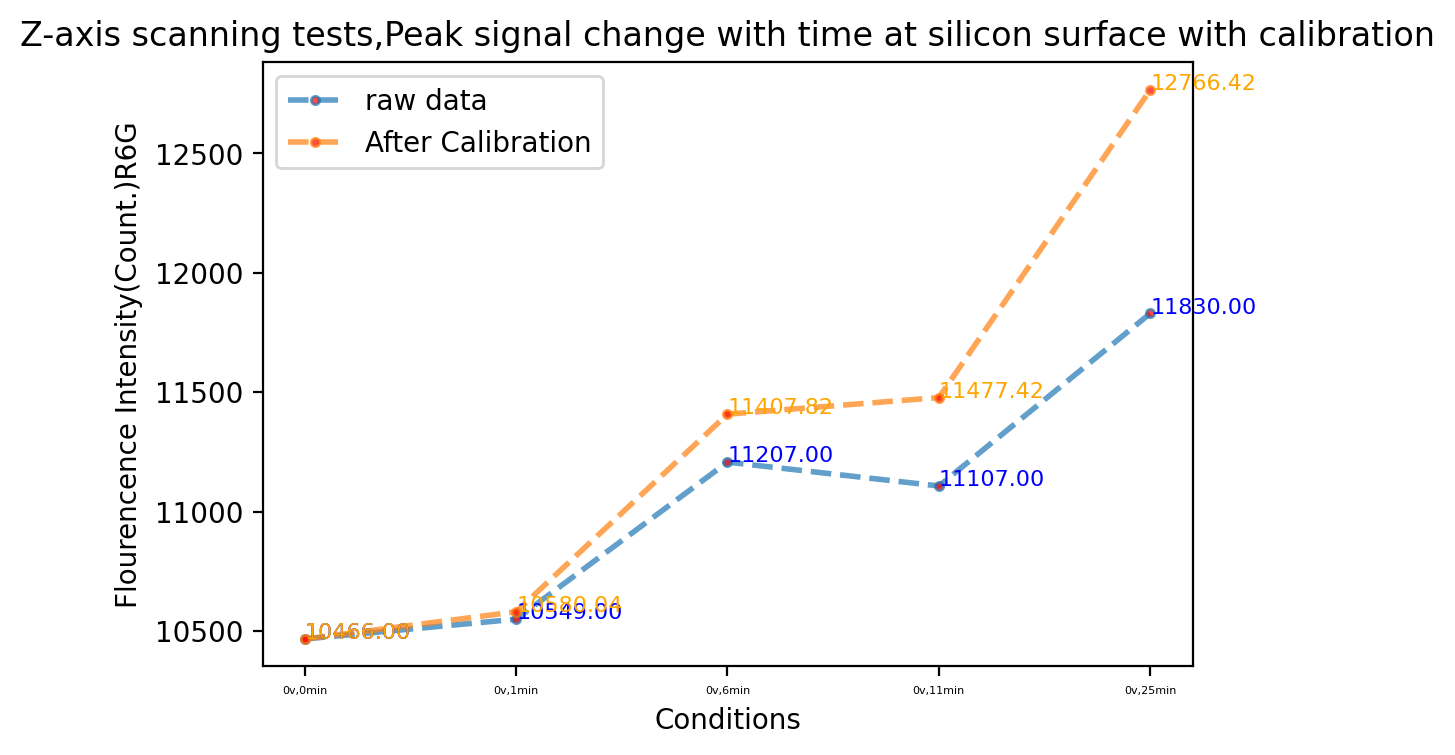

In [ ]:
upper_class_path = '/content/drive/MyDrive/analysis/Raman_analyze/20230127 r6g/5um PMMA coated sinw voltage/location 1/0v Laser effect'
save_path = upper_class_path
description_label = 'Z-axis scanning tests,Peak signal change with time at silicon surface with calibration'
cali_param = (-4.89e-5,1)
cali_param2 =(-1.989e-4,1)
position,intensity,condition_label,_=get_maxpoints_position_value(upper_class_path,peak_position_approx=(1500,1600),linear_cali_param=cali_param,linear_cali_param2=cali_param2)
position2,intensity2,_,_=get_maxpoints_position_value(upper_class_path,peak_position_approx=(1500,1600))
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
x = [i+1 for i in range(len(intensity))]
x_labels = condition_label
plt.xticks(x, x_labels,fontsize=4)
ax.plot(x,intensity2,'.--',markerfacecolor='red',alpha = .7,linewidth=2,label='raw data')
ax.plot(x , intensity,'.--',markerfacecolor='red',alpha = .7,linewidth=2,label='After Calibration')
# ax.legend(condition_list,fontsize=4,loc='upper left')
for i in range(len(x)):
  ax.text(x[i],intensity2[i],'%.2f'%intensity2[i],fontsize=8,color='blue')
for i in range(len(x)):
  ax.text(x[i],intensity[i],'%.2f'%intensity[i],fontsize=8,color='orange')

ax.set(ylabel='Flourencence Intensity(Count.)R6G',xlabel='Conditions')
ax.set(title= '%s'%description_label)
ax.legend()
# ax.title.set_size(8)
ax.autoscale()
plt.savefig(save_path+'%s%s.png'%(upper_class_path.split('/')[-1],description_label),dpi=600)
print(position)

### Calibrate the peak

  0%|          | 0/5 [00:00<?, ?it/s]

the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_22.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_4.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_12.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_27.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_27.txt:   5%|▌         | 4/75 [00:00<00:02, 34.75it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forward_sysmmetry_location 1_62.txt:   5%|▌         | 4/75 [00:00<00:02, 34.75it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,0min_forwa

finished drawing <Calibrated Z-Axis scanning test data R6G 1e-7M raw,0v Laser effect,0v,0min> figure
the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_28.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_1.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_51.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_47.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_47.txt:   5%|▌         | 4/75 [00:00<00:02, 34.07it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forward_sysmmetry_location 1_14.txt:   5%|▌         | 4/75 [00:00<00:02, 34.07it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,1min_forwa

finished drawing <Calibrated Z-Axis scanning test data R6G 1e-7M raw,0v Laser effect,0v,1min> figure
the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_46.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_35.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_43.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_3.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_3.txt:   5%|▌         | 4/75 [00:00<00:02, 35.39it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forward_sysmmetry_location 1_30.txt:   5%|▌         | 4/75 [00:00<00:02, 35.39it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,6min_forwar

finished drawing <Calibrated Z-Axis scanning test data R6G 1e-7M raw,0v Laser effect,0v,6min> figure
the distance gap is 30 um



  0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_18.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_8.txt:   0%|          | 0/74 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_32.txt:   0%|          | 0/74 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_32.txt:   4%|▍         | 3/74 [00:00<00:04, 17.75it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_1.txt:   4%|▍         | 3/74 [00:00<00:04, 17.75it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,11min_forward_sysmmetry_location 1_20.txt:   4%|▍         | 3/74 [00:00<00:04, 17.75it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo

finished drawing <Calibrated Z-Axis scanning test data R6G 1e-7M raw,0v Laser effect,0v,11min> figure
the distance gap is 30 um



  0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_48.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_1.txt:   0%|          | 0/75 [00:00<?, ?it/s] 
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_37.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_68.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_36.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmmetry_location 1_26.txt:   0%|          | 0/75 [00:00<?, ?it/s]
Now processing inner circle...on PMMA SINW_R6G1e-7_560uw_ITo_0v,25min_forward_sysmme

finished drawing <Calibrated Z-Axis scanning test data R6G 1e-7M raw,0v Laser effect,0v,25min> figure


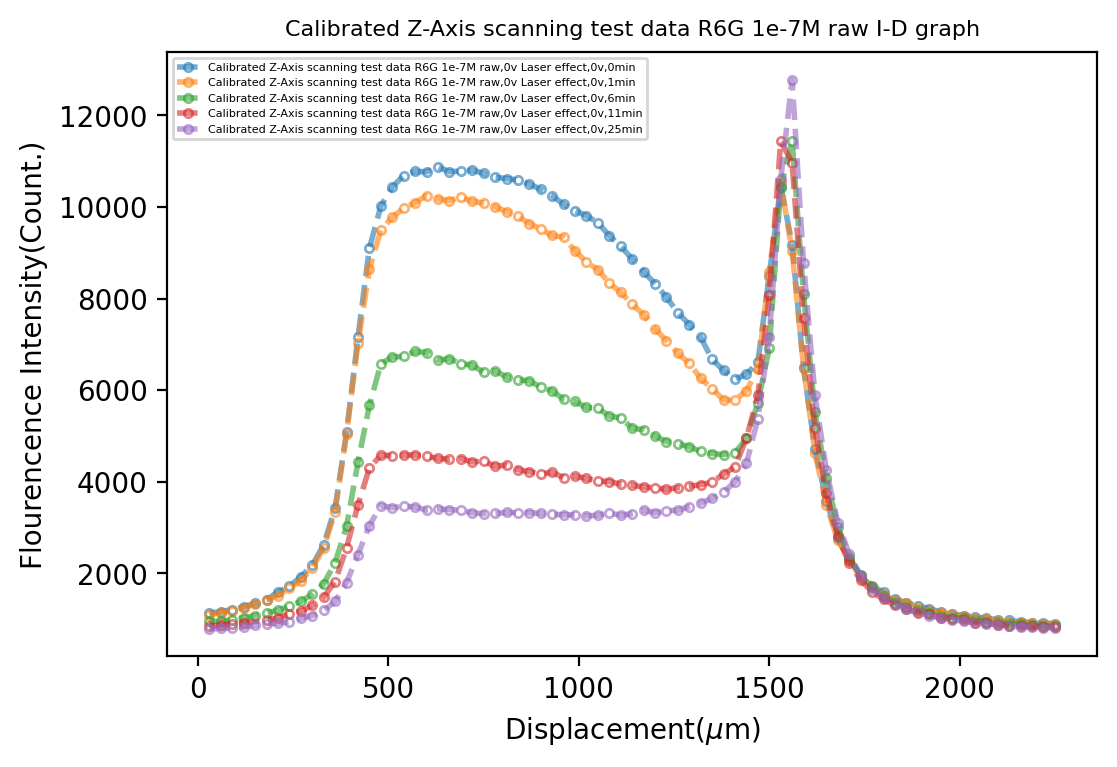

In [ ]:
#upper_class_path = '/content/drive/MyDrive/analysis/Raman_analyze/20230127 r6g/5um PMMA coated sinw voltage/location 1/total/'
save_path =upper_class_path
cali_param_list= ['1.00', '1.00', '1.02', '1.03', '1.08']
solution_concentration = 'R6G 1e-7M ' 
name = 'Calibrated Z-Axis scanning test data ' + solution_concentration
mode1 = 'individual'
mode2 ='overall'
mode3 ='raw'
Calibrationed_Distance_raman_drawing(upper_class_path,save_path,name+mode3,mode3,cali_param_list)

## Extract the max point position

In [ ]:

def keep_cetain_position_inlist(tot_folder_path):


In [ ]:
condition = file_path.split('/')[-1]
print(condition)

2ITO+1V


In [ ]:
from IPython.lib.display import isdir
import os
def return_folders_path(path):
  path_list = []
  for top,dirs,files in os.walk(Upper_folder_path):
    for dir in dirs:
      path=os.path.join(top,dir)
      path_list.append(path)
  return path_list

def return_files_path(path):
  file_list = []
  for top,dirs,files in os.walk(Upper_folder_path):
    for file in files:
      path=os.path.join(top,file)
      file_list.append(path)
  return file_list

def delete_upper_class_folder_path(path_list):
  for path in path_list:
    for item in os.listdir(path):
      if os.path.isdir(item):
        path_list.remove(path)
  return path_list
  
def delete_upper_class_folder_path(path_list):
  for path in path_list:
    file_list = os.listdir(path)
    for file in file_list:
      print(file)
      if os.path.isdir(os.path.join(path,file)):
        path_list.remove(path)
        print('removing upper folder%s'%path)
        break#遇到第一个folder 删除上级路径
  return path_list

Upper_folder_path = '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO'
condition_list =[]
path_c = return_folders_path(Upper_folder_path)
path_b = delete_upper_class_folder_path(path_c)


for path in path_c:
  print(path+'---')

  #for f_path in path:
for path in path_b:
  print(path)

1
removing upper folder/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv
R6G 10-6M on FTO_-0vafter-1v_5min_2_7.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_16.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_30.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_37.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_20.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_21.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_4.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_39.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_11.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_14.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_41.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_36.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_29.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_6.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_19.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_13.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_32.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_31.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_23.txt
R6G 10-6M on FTO_-0vafter-1v_5min_2_33.txt
R

In [ ]:
test_path ='/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v'
for item in os.listdir(test_path):
  if os.path.isdir(os.path.join(test_path,item)):
    print('kk')

kk
kk


In [ ]:
path_d = delete_upper_class_folder_path(path_b)
print(path_d)

5min
removing upper folder/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v
R6G 10-6M on FTO_0mv_1_11.txt
R6G 10-6M on FTO_0mv_1_6.txt
R6G 10-6M on FTO_0mv_1_12.txt
R6G 10-6M on FTO_0mv_1_13.txt
R6G 10-6M on FTO_0mv_1_15.txt
R6G 10-6M on FTO_0mv_1_10.txt
R6G 10-6M on FTO_0mv_1_5.txt
R6G 10-6M on FTO_0mv_1_1.txt
R6G 10-6M on FTO_0mv_1_2.txt
R6G 10-6M on FTO_0mv_1_3.txt
R6G 10-6M on FTO_0mv_1_9.txt
R6G 10-6M on FTO_0mv_1_16.txt
R6G 10-6M on FTO_0mv_1_8.txt
R6G 10-6M on FTO_0mv_1_14.txt
R6G 10-6M on FTO_0mv_1_4.txt
R6G 10-6M on FTO_0mv_1_7.txt
R6G 10-6M on FTO_0mv_1_23.txt
R6G 10-6M on FTO_0mv_1_39.txt
R6G 10-6M on FTO_0mv_1_44.txt
R6G 10-6M on FTO_0mv_1_45.txt
R6G 10-6M on FTO_0mv_1_28.txt
R6G 10-6M on FTO_0mv_1_29.txt
R6G 10-6M on FTO_0mv_1_25.txt
R6G 10-6M on FTO_0mv_1_34.txt
R6G 10-6M on FTO_0mv_1_17.txt
R6G 10-6M on FTO_0mv_1_42.txt
R6G 10-6M on FTO_0mv_1_18.txt
R6G 10-6M on FTO_0mv_1_22.txt
R6G 10-6M on FTO_0mv_1_3

In [ ]:
path_d

['/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/-0vafter-1v',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv/1',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv/2',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv/3',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v/5min',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v/1',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/-1v/1',
 '/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO

In [ ]:
os.listdir('/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v/')

['5min', '1']

In [ ]:
from posixpath import join
from posixpath import split
from pandas.io.parsers.readers import read_table



# KEY_WORDS = {'voltage':['N50mv'],'time':['0-200s']}
# file_list = file_name_walk_finder(file_path,KEY_WORDS)

def itgraph_value_return(file_list,Autopickfinder_FLAG = True):

  # time_count_list = []
  # target_y = []
  Autopickfinder_FLAG = True
  plot_list = np.array([[0,0]])
  for file in file_list:
    initial_num = int(file.split('_')[1].split('-')[0])
    time_count = int(file.split('_')[-1].split('.')[0].lower())
    # time_count_list.append(time_count*10+initial_num)
    files = os.path.join(file_path,file)
    df = pd.read_table(files,names=['wave number','intensity'],sep='\\s+',encoding='utf-8')
    df = df.loc[df['wave number']>400].reset_index()
    y = df['intensity']
    base = peakutils.baseline(y,5)
    
    if Autopickfinder_FLAG == True:
      
      indexes = peakutils.indexes(y-base,thres=0.01,min_dist=20)
      ## Debug and check the peak finder
      print(indexes)
      #index = indexes[np.where((indexes<135)&(indexes>130))]
      Y_2=0
      for indexe in indexes:
        if 700 <df['wave number'].loc[indexe]<750:
          index = indexe
          #### debug
          print(df['wave number'].loc[indexe])
          Y_2 = df['intensity'].loc[index]-base[index]
    else: 
      index =  df[df['wave number']==733.004].index.tolist()
      Y_2 = df['intensity'].loc[index[0]]-base[index[0]]
      print(df['wave number'].loc[index[0]])
      
        
    # target_y.append(Y_2)
    #print(index)
    time_gap = 10
    plot_list =np.append(plot_list,[[time_count*time_gap+initial_num,Y_2]],axis=0)
    # print(np.argsort(plot_list[:,0]))

    plot_list = plot_list[np.argsort(plot_list[:,0])]
    # print(plot_list)
  return plot_list


In [ ]:
from matplotlib import text
from pandas.core import indexes
dest=[]
target = ['N800mv']
target.sort()
file_path = '/content/drive/MyDrive/Ph.D./Lab/SERS-Si Array/data/Roman/july23 1e-7 14s3hours/N800(4)'
with plt.style.context(['science','no-latex']):
    fig, ax = plt.subplots(figsize=(6,4),dpi=200)
    plt.ylim((-10,10000))
    #plt.xlim((50,600))
    for tar in target:
      KEY_WORDS = {'voltage':[tar],'time':['0-600s']}
      file_list = file_name_walk_finder(file_path,KEY_WORDS)
      plot_list = itgraph_value_return(file_list)
      print(plot_list)
      x_value = plot_list[1:,0]
      y_value = plot_list[1:,1]
      ax.plot(x_value , y_value,'b.--',markerfacecolor='none')
      des = tar +' Applied voltage time,1200s,Cumulative,733$cm^{-1} around$'
      dest.append(des)
      ax.legend(dest,fontsize=6)
      concentration = '$10^{-7}$M Adenine(PBS 0.1X)'
    ax.legend(["Voltage," + target[0] +",signal changed recording "],fontsize=6,loc='upper right')
    ax.set(ylabel='733$cm^{-1}$ around Intensity(Count.)',xlabel='time(s)')
    ax.set(title= target[0]+','+concentration +', I-t graph')
    ax.autoscale()

OSError: ignored

In [ ]:
Upper_folder_path ='/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO'
for top,dirs,files in os.walk(Upper_folder_path):
  for dir in dirs:
    path=os.path.join(top,dir)
    print(path)

/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/-0vafter-1v
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/-1v
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv/1
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv/2
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/0mv/3
/content/drive/MyDrive/analysis/Raman_analyze/20221215 BL/Filter_test/R6G_12_15_ refine holder_60/R6G 10-6M on FTO/+1v/5min
/content/drive/MyDrive/analys

In [ ]:
from tqdm import tqdm
a =['12','23','3','1']
bar = tqdm(a)
for a in bar:
  bar.set_description('Now processing...%s'%a)
  print(type(bar))
  


Now processing...1: 100%|██████████| 4/4 [00:00<00:00, 299.42it/s]

<class 'tqdm.std.tqdm'>
<class 'tqdm.std.tqdm'>
<class 'tqdm.std.tqdm'>
<class 'tqdm.std.tqdm'>
